In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn. import 

seed = 42

In [ ]:
#Load data
df = pd.read_csv(os.path.abspath("../data/labeled_training_data.csv"))

#Select all columns except the last
X = df.iloc[:, :-1]

#Create new features
X['day_or_night'] = X['hour_of_day'].apply(lambda x: 1 if 6 <= x < 20 else 0)

#X['sky_condition'] = X['visibility'] * X['cloudcover'] + X['precip']

#X['normal_day'] = (~((X['summertime'] == 1) | (X['holiday'] == 1) | (X['weekday'] == 0))).astype(int)

#X['apparent_temperature'] = X['temp'] + 0.33*(X['humidity']/100*6.105*np.exp(17.27*X['temp']/(237.7+X['temp']))) - 0.70*X['windspeed'] - 4.00

#Remove bad features
#X = X.drop(['summertime', 'holiday', 'cloudcover', 'visibility', 'snow', 'snowdepth'], axis=1)
#X = X.drop(['summertime', 'holiday', 'cloudcover', 'visibility', 'snow', 'snowdepth', 'weekday', 'precip', 'windspeed', 'month', 'day_of_week'], axis=1)
X = X.drop(['snow', 'snowdepth', 'holiday'], axis=1)

X.info()

#Select label column
y = df['increase_stock']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=seed)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hour_of_day   1600 non-null   int64  
 1   day_of_week   1600 non-null   int64  
 2   month         1600 non-null   int64  
 3   weekday       1600 non-null   int64  
 4   summertime    1600 non-null   int64  
 5   temp          1600 non-null   float64
 6   dew           1600 non-null   float64
 7   humidity      1600 non-null   float64
 8   precip        1600 non-null   float64
 9   windspeed     1600 non-null   float64
 10  cloudcover    1600 non-null   float64
 11  visibility    1600 non-null   float64
 12  day_or_night  1600 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 162.6 KB


In [ ]:
model = RandomForestClassifier( 
    random_state=seed,
    # n_estimators=145,
    # max_depth=24,
    class_weight='balanced_subsample',
    # min_samples_leaf=1,
    # min_samples_split=2,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    n_jobs=-1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', model)])

param_dists = {
    'n_estimators': np.linspace(90, 350, num=80, dtype=int),      
    'max_depth': np.linspace(15, 150, num=50, dtype=int),              
    'min_samples_split': np.linspace(2, 20, num=18, dtype=int),      
    'min_samples_leaf': np.linspace(1, 8, num=8, dtype=int),                                   
   # 'bootstrap': [True, False],                                       
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dists,
    n_iter=1000,
    scoring='f1',
    refit=True, 
    cv=skf,
    n_jobs=-1,
    verbose=3,
    return_train_score=False,
    random_state=seed,
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)
print(f"\nBest {random_search.refit} Score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: 

In [ ]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1-Weighted: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test Recall-Weighted: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test Precision-Weighted: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

Test Accuracy: 0.8594
Test F1-Weighted: 0.8673
Test Recall-Weighted: 0.8594
Test Precision-Weighted: 0.8810
Test ROC AUC: 0.9067
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       270
           1       0.54      0.72      0.62        50

    accuracy                           0.86       320
   macro avg       0.74      0.80      0.76       320
weighted avg       0.88      0.86      0.87       320



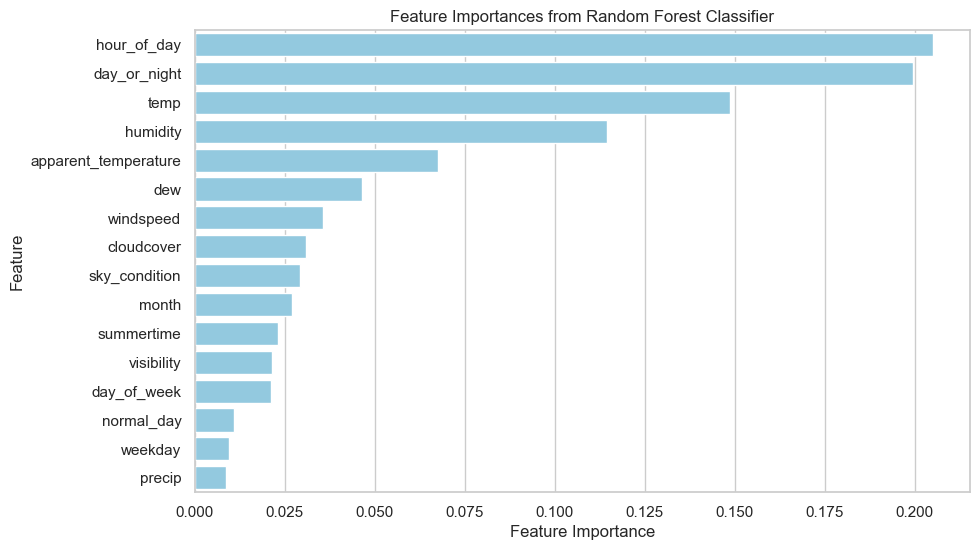

In [ ]:
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot using Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Classifier')
plt.show()